# About this notebook
This notebook is an example of how to perform the following tasks:
* Export polygon properties for cropped track regions, with optional curation

## Python imports
The cell below deals with importing necessary packages and dependencies for running the notebook. You know the drill by now.

In [1]:
import scipy.optimize as opt
import numpy as np
import matplotlib.pylab as plt
from glob import glob
from tifffile import imread
from scipy.ndimage.filters import gaussian_filter
import csv
from os.path import isfile
from skimage.draw import polygon
from skimage.measure import regionprops
from skimage.morphology import binary_dilation
from tqdm.notebook import tqdm
import pickle
from scipy.spatial.distance import euclidean as euc


from pathlib import Path

## File information
The below cell tells the code where to find the file(s) to analyse, and also any preferences you have for the analysis.

### File location
`base_dir` is the path containing the folder structure with outputs from the `Process_trackmate.ipynb` notebook and if applicable the `Curation_helper.ijm` ImageJ macro.

### Analysis options
`two_colour_analysis` is a flag to tell the code whether the analysis was performed on two-colour data or not. This should be set to `True` if it was, otherwise this should be `False`.

`tracked_channel` is the channel number that was used for tracking (should be `1` or `2`). This value doesn't matter for single colour datasets.

`do_curation` is a flag to tell the code whether there is a list of curated datasets. The instructions for running this are at the end of the `Process_trackmate.ipynb` notebook.

In [2]:
base_dir = r'.\data\two-colour data'

two_colour_analysis = True
tracked_channel = 1

do_curation = True

This cell finds the relevant directories and the curation list, if provided.

In [3]:
def get_curation_list(crop_dir):
    
    f = f'{crop_dir}\curated_results.csv'
    try:
        reader = csv.reader(open(f), delimiter=',')
    except FileNotFoundError:
        print(f'ERROR: No file named curated_results.csv was found in the directory {crop_dir}...')
        raise
        
    rows = list(reader)
    curated = []
    
    for row in rows:
        if row[-1] == 'Slice':
            continue
        val = int(row[-1])-1
        if val<10:
            curated.append(f'00{val}')
        elif val<100:
            curated.append(f'0{val}')
        else:
            curated.append(f'{val}')
            
    return curated

def get_indices_of_tracks(crop_dir):
    
    tif_dir = Path(crop_dir / f'tifs')
    tif_files = sorted(tif_dir.rglob('*'))
    indices_list = []
    
    for tif_file in tif_files:
        indices_list.append(tif_file.stem[-3:])
    
    return indices_list
    
    
base_dir = Path(base_dir)

results_dir = Path(base_dir / f'results')
crops_list = sorted(results_dir.rglob('crops*'))
n_datasets = len(crops_list)

print(f'There are {n_datasets} datasets to analyse')

analysis_lists = []
if do_curation:
    for i in range(n_datasets):
        curated = get_curation_list(crops_list[i])
        analysis_lists.append(curated)
        print(f'--There are {len(curated)} crops to analyse in dataset {crops_list[i]}.')
else:
    for i in range(n_datasets):
        indices = get_indices_of_tracks(crops_list[i])
        analysis_lists.append(indices)
        print(f'--There are {len(indices)} crops to analyse in dataset {crops_list[i]}.')



There are 2 datasets to analyse
--There are 7 crops to analyse in dataset data\two-colour data\results\crops_membrane_dna_1.
--There are 1 crops to analyse in dataset data\two-colour data\results\crops_membrane_dna_2.


The next cell gathers corresponding files for a specific crop (track).

In [4]:
def get_paths_for_current_crop(index, crop_dir, two_colour_analysis):

    tif_dir = Path(crop_dir / f'tifs')
    tif_file = sorted(tif_dir.rglob(f'*{index}*'))[0]
    
    mask_dir = Path(crop_dir / f'mask tifs')
    mask_file_tracked = sorted(mask_dir.rglob(f'*{index}*'))[0]
    mask_file_untracked = None
    
    if two_colour_analysis:
        mask_file_untracked = sorted(mask_dir.rglob(f'*{index}*'))[0]

    rois_dir = Path(crop_dir / f'polygons')
    rois_file_tracked = sorted(rois_dir.rglob(f'*{index}*'))[0]
    rois_file_untracked = None
    
    if two_colour_analysis:
        rois_file_untracked = sorted(rois_dir.rglob(f'*{index}*'))[0]
    
    return tif_file, mask_file_tracked, mask_file_untracked, rois_file_tracked, rois_file_untracked

Preview the masks of the first dataset...

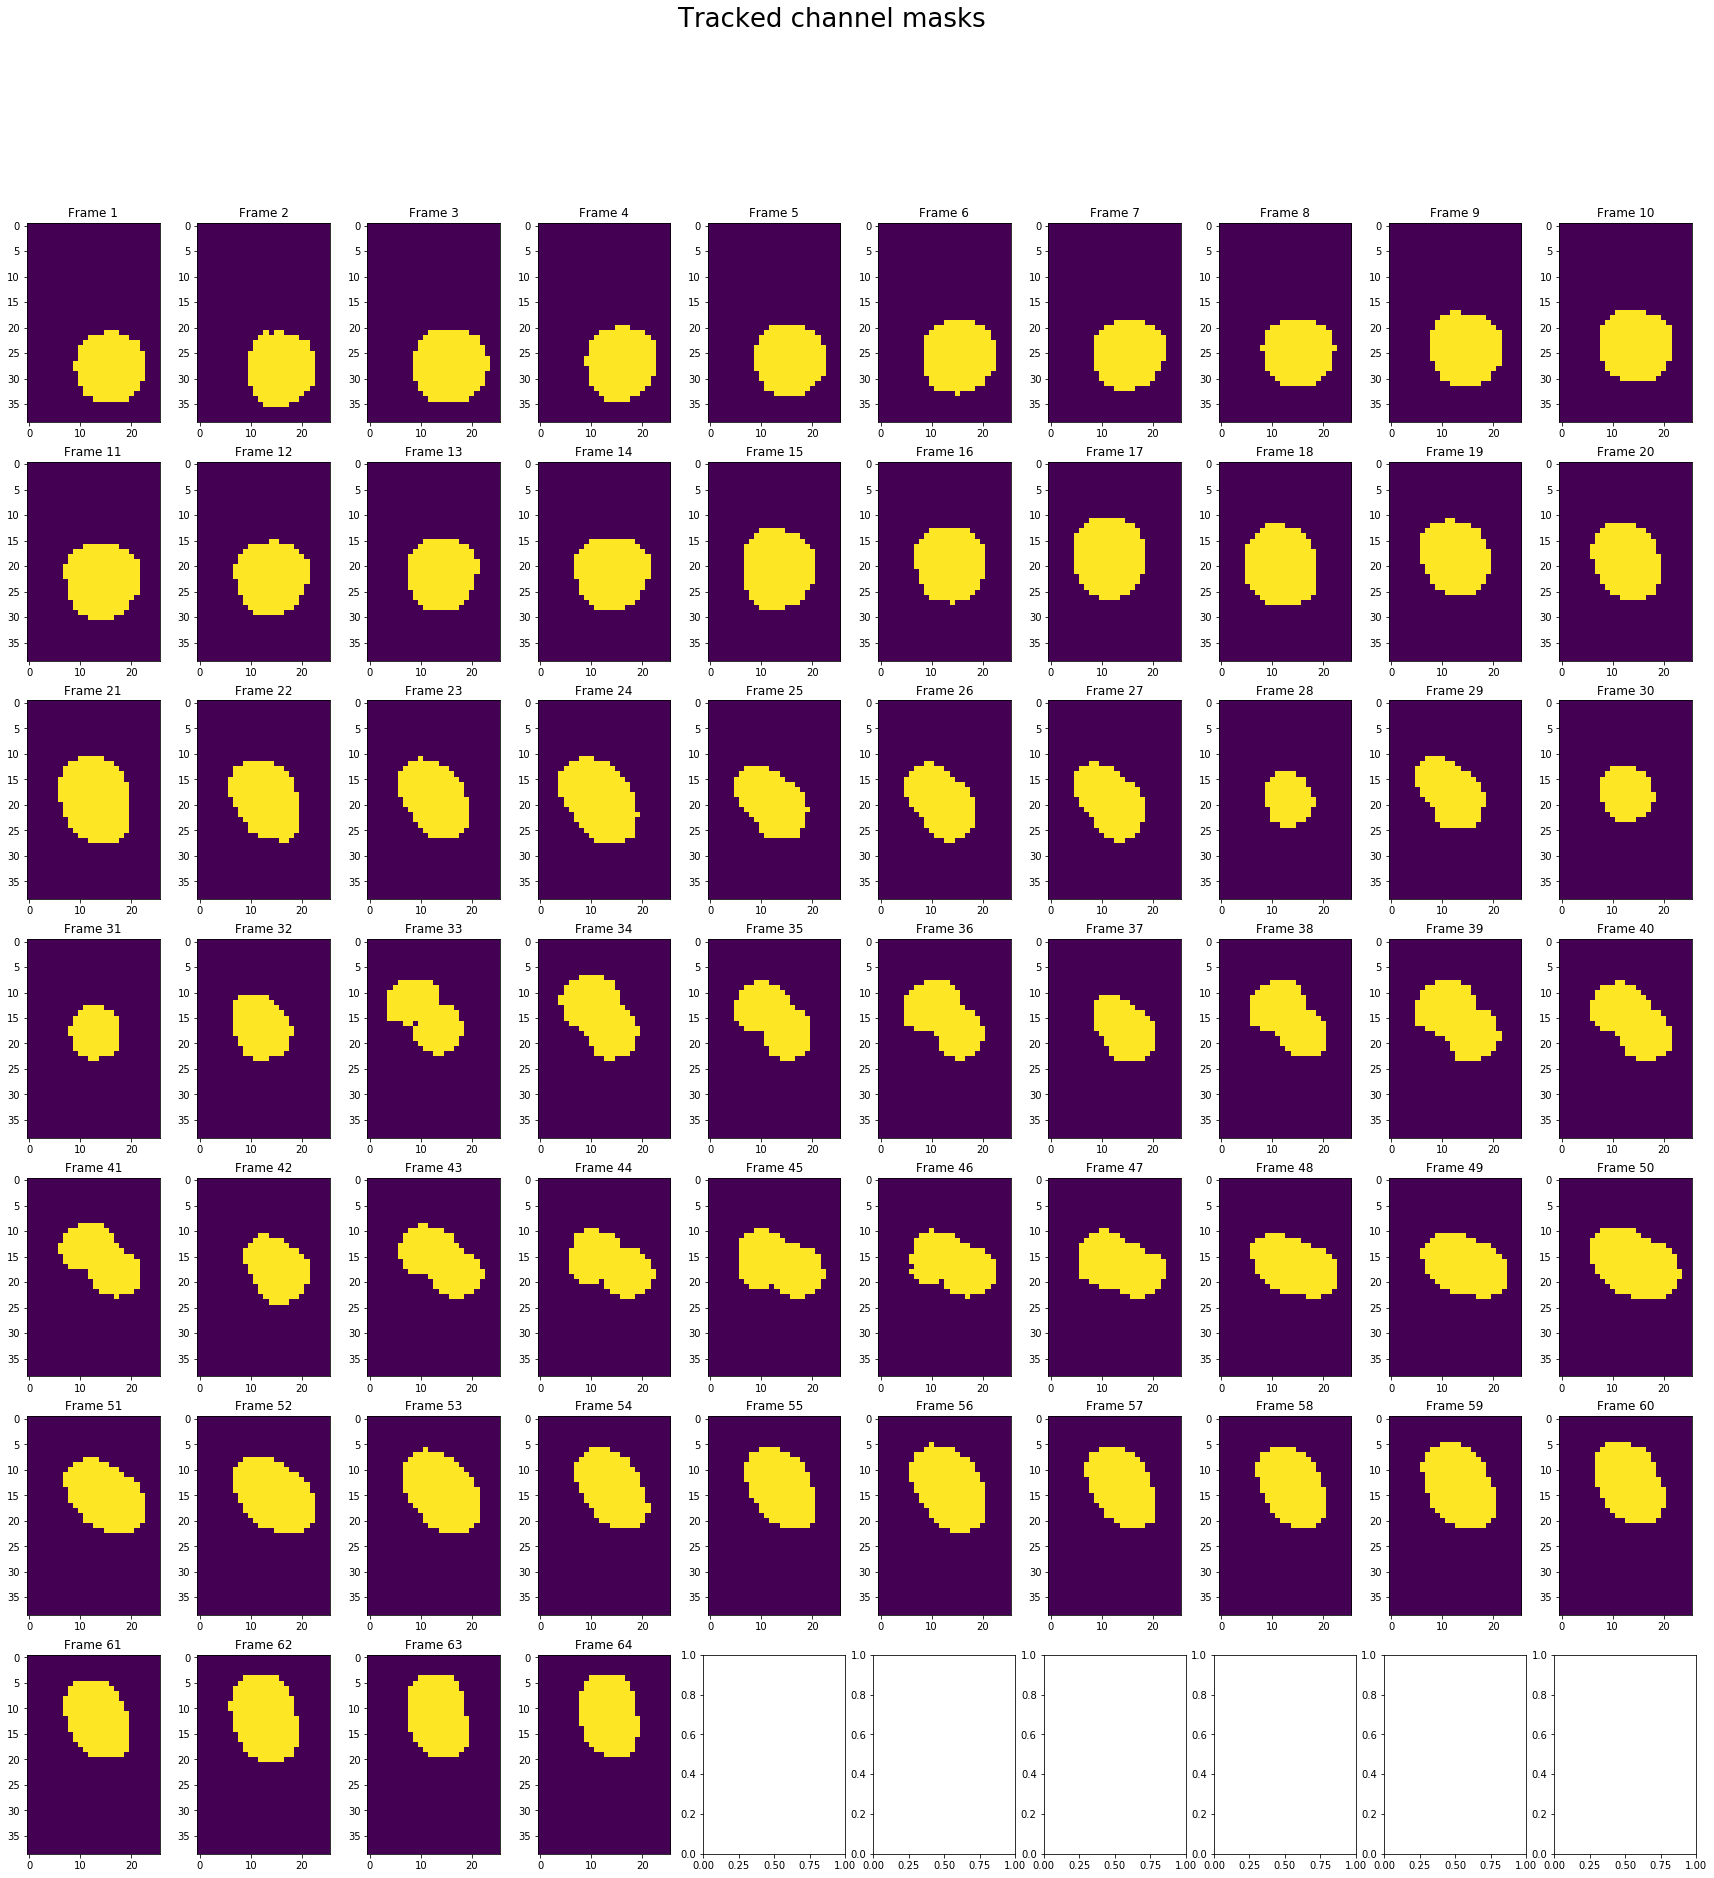

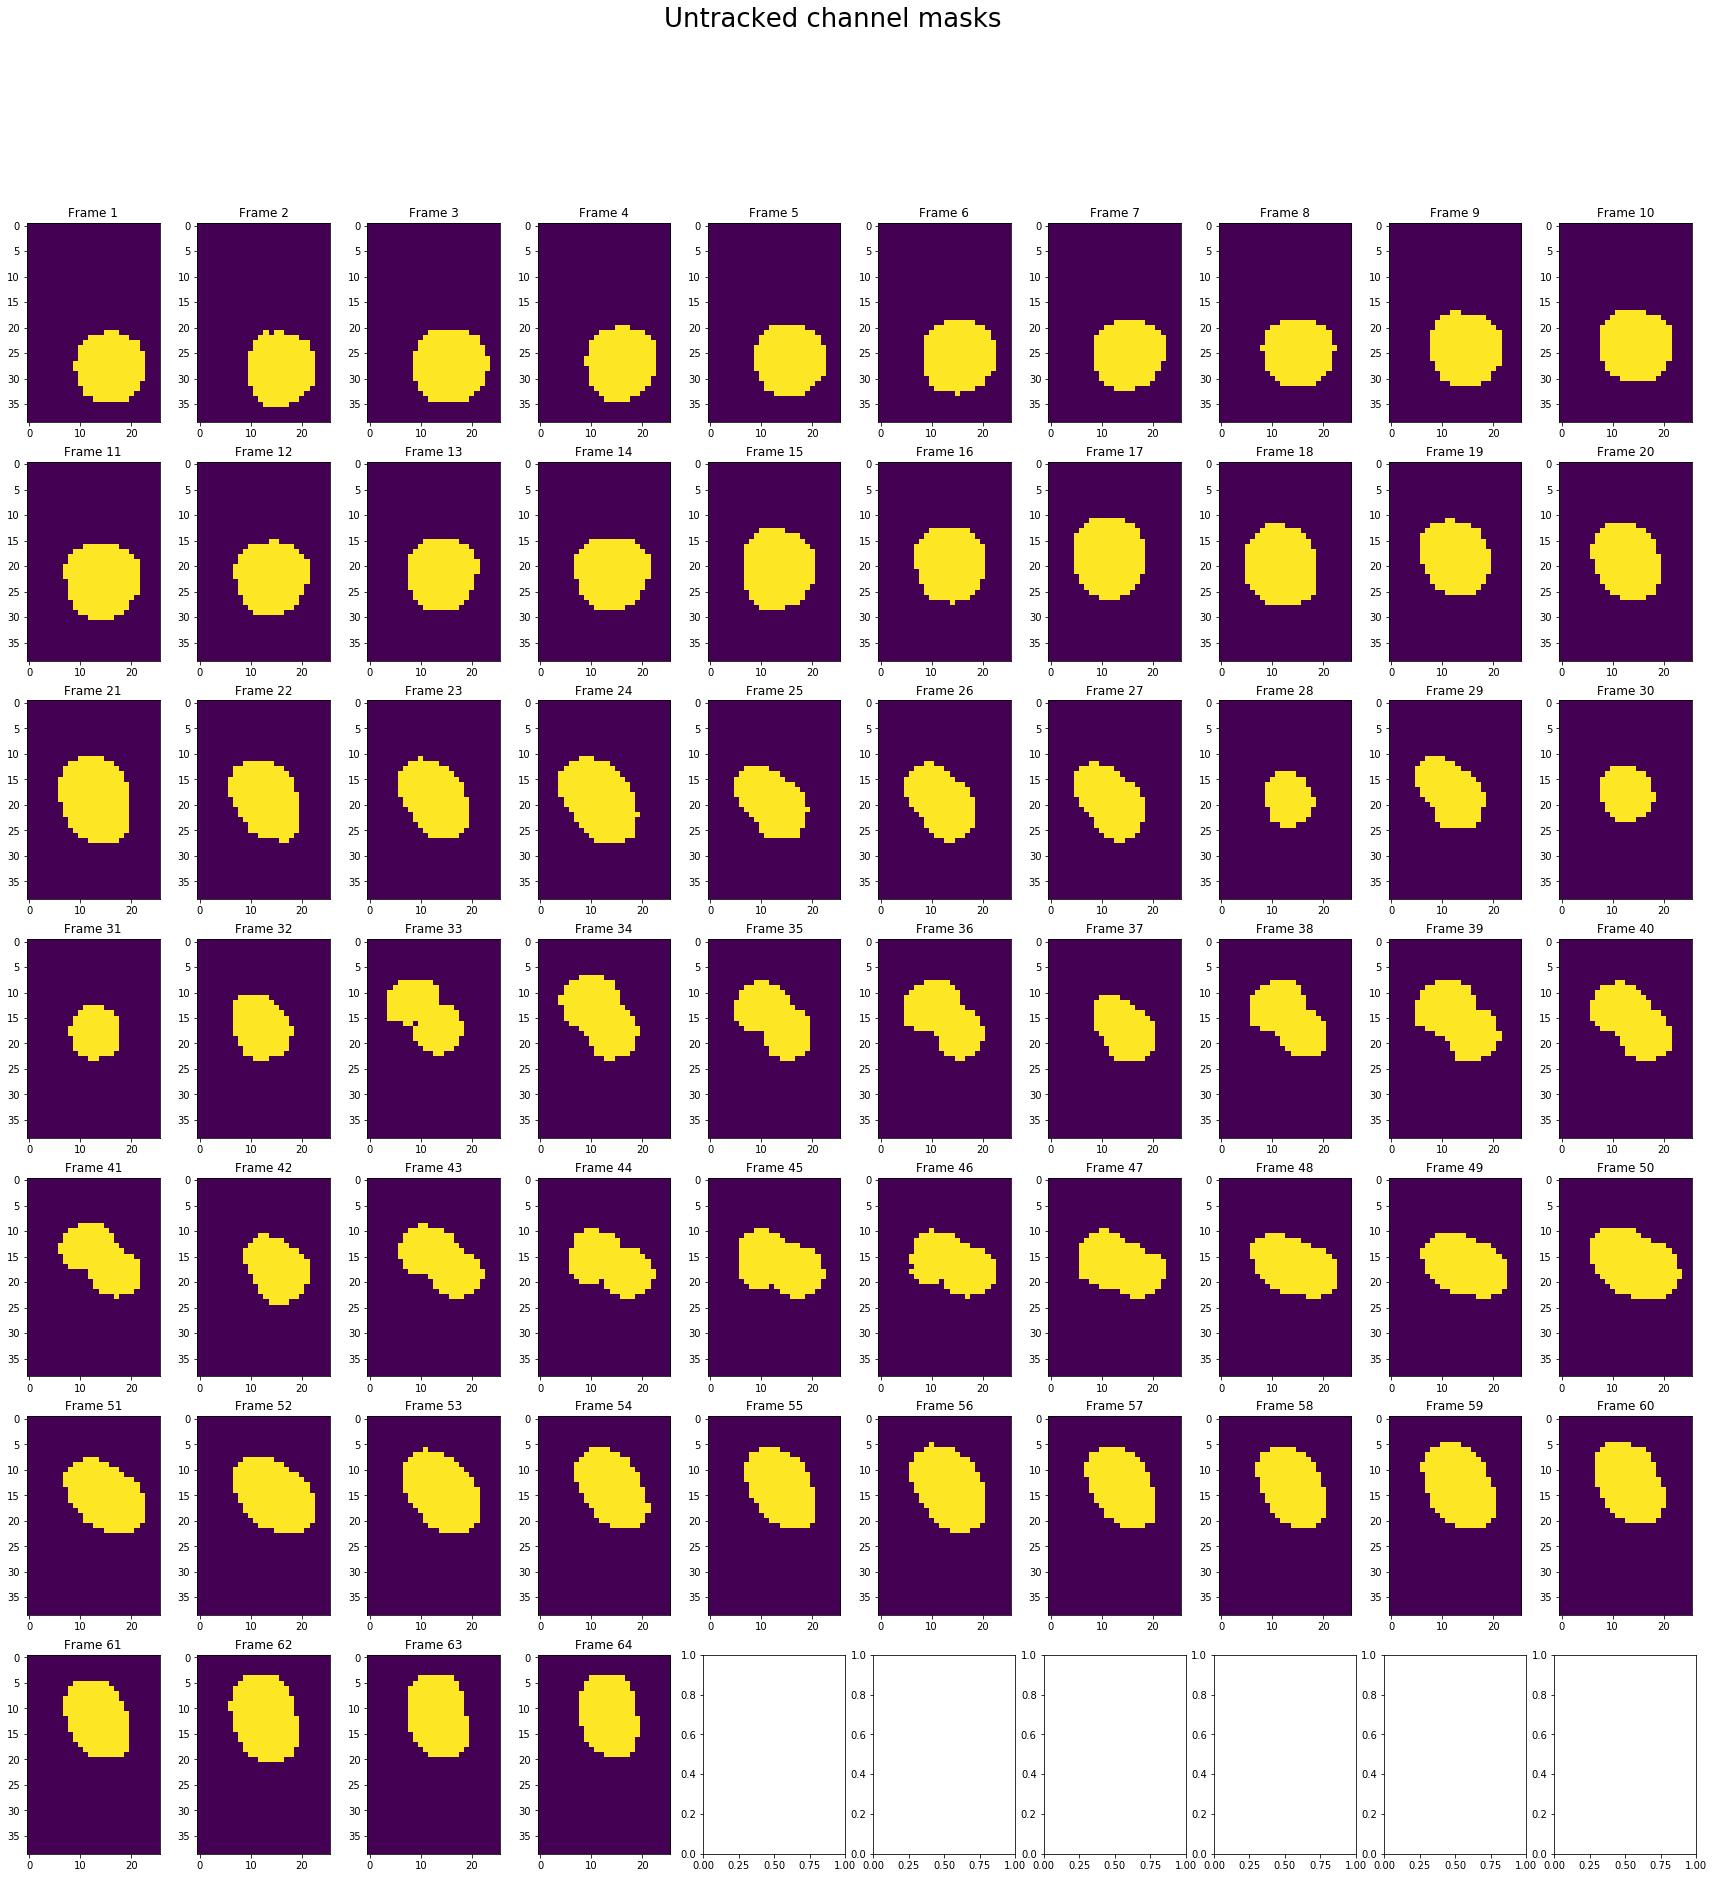

In [5]:
dataset = 0
analysis_list = analysis_lists[dataset]
this_crop = analysis_list[0]

tif_file, mask_file_tracked, mask_file_untracked, rois_file_tracked, rois_file_untracked = (
    get_paths_for_current_crop(this_crop, crops_list[dataset], two_colour_analysis))

T_tracked = imread(str(mask_file_tracked))

n_images = T_tracked.shape[0]
n_cols = 10
n_rows = int(np.ceil(n_images/n_cols))

fig_tracked, ax_tracked = plt.subplots(n_rows, n_cols, figsize=[30,30], frameon=False)
for n in range(n_images):
    loc = np.unravel_index(n, (n_rows, n_cols))
    ax_tracked[loc].imshow(T_tracked[n])
    ax_tracked[loc].set_title(f'Frame {n+1}')
fig_tracked.suptitle('Tracked channel masks', fontsize=26)

if two_colour_analysis:
    T_untracked = imread(str(mask_file_untracked))
    
    fig_untracked, ax_untracked = plt.subplots(n_rows, n_cols, figsize=[30,30], frameon=False)
    for n in range(n_images):
        loc = np.unravel_index(n, (n_rows, n_cols))
        ax_untracked[loc].imshow(T_untracked[n])
        ax_untracked[loc].set_title(f'Frame {n+1}')
    fig_untracked.suptitle('Untracked channel masks', fontsize=26)

need to make a separate mask for each polygon in frame and then do measurements
if more than 2 rois in a frame then reject most eccentric polygon?

go to each frame, check number of rois.
if no rois, skip frame
if one roi, measure area, circularity, centroid. do single and double gaussian fits on masked dna channel.
if two rois, measure areas. circulatirities, centroids. do single and double gaussian fits of masked dna channel.
if more than two rois, keep the two rois with greatest distance between their centroids.

In [6]:
def get_polygon_props(frame, image, rois_file):
    shape = image.shape[-2:]
    polygons = np.load(str(rois_file), allow_pickle=True)['coord'][frame]
    
    n_polygons = len(polygons)  
    
    if n_polygons == 0:
        return None
    
    polygon_props = []
    
    # get regionprops from each masked polygon
    for p in range(n_polygons):
        roi = polygons[p]
        lbl = np.zeros(shape, np.uint8)
        rr,cc = polygon(roi[0], roi[1], lbl.shape)
        lbl[rr,cc] = 255
        
        props = regionprops(lbl)[0]
        polygon_props.append(props)
        
    # for cell division, more than two polygons in a track is not correct
    if len(polygon_props)>2:
        far_dist = 0
        far_pair = [0,0]
        
        # identify and retain furthest-separated polygon pair
        for i in range(len(polygon_props)):
            centroid_i = polygon_props[i].centroid
            for j in range(i+1, len(polygon_props)):
                centroid_j = polygon_props[j].centroid
                dist = euc(centroid_i, centroid_j)
                if dist>far_dist:
                    far_dist = dist
                    far_pair = [i,j]
        
        polygon_props_ = polygon_props
        polygon_props = []
        polygon_props.append(polygon_props_[far_pair[0]])
        polygon_props.append(polygon_props_[far_pair[1]])
        
    n_polygons = len(polygon_props)
    for p in range(n_polygons):
        props = polygon_props[p]

    return polygon_props

def get_polygon_mean_signal(image, poly):
    shape = image.shape[-2:]
    rr,cc = polygon(poly[0], poly[1], shape)
    
    return np.mean(image[rr,cc])

In [18]:
def get_props_dict(image, frame_number, rois, polygon_props, polygon_idx):
        
    polygon = np.load(str(rois), allow_pickle=True)['coord'][frame_number][polygon_idx]
    signal = get_polygon_mean_signal(image, polygon)
    props = polygon_props[polygon_idx]
        
    props_dict = {'c':props.centroid, 
                 'area':props.area,
                 'ecc':props.eccentricity, 
                 'sig':signal, 
                 'maj':props.major_axis_length, 
                 'min':props.minor_axis_length}

    return props_dict

def process_frame(frame_number, tif_file, mask_tracked, mask_untracked, rois_tracked, rois_untracked, tracked_channel):
    
    # get current frame for image, deal with channels
    image = imread(str(tif_file))
    
    if len(image.shape)==3:
        image_tracked = image[frame_number]
        
    if len(image.shape)==4:
        if tracked_channel==1:
            image_tracked = image[frame_number,0,:,:]
            image_untracked = image[frame_number,1,:,:]
        elif tracked_channel==2:
            image_tracked = image[frame_number,1,:,:]
            image_untracked = image[frame_number,0,:,:]
        else:
            raise ValueError('Got a weird value for tracked_channel! Computer says no.')
    
    # get image masks and polygon properties
    image_masks_tracked = imread(str(mask_tracked))
    if mask_untracked is not None:
        image_masks_untracked = imread(str(mask_untracked))
    
    polygon_props_tracked = get_polygon_props(frame_number, image_tracked, rois_tracked)
    if rois_untracked is not None:
        polygon_props_untracked = get_polygon_props(frame_number, image_untracked, rois_untracked)
    
    # populate dictionary with polygon properties for current frame
    crop_dict = {}
    
    if polygon_props_tracked==None:
        crop_dict['tracked'] = []
    else:
        tracked_1 = get_props_dict(image_tracked, frame_number, rois_tracked, polygon_props_tracked, 0)

        if len(polygon_props_tracked)==1:
            crop_dict['tracked'] = [tracked_1]

        elif len(polygon_props_tracked)==2:
            tracked_2 = get_props_dict(image_tracked, frame_number, rois_tracked, polygon_props_tracked, 1)
            crop_dict['tracked'] = [tracked_1, tracked_2]
    
    if rois_untracked is not None:
        
        if polygon_props_untracked==None:
            crop_dict['untracked'] = []
        else:
            untracked_1 = get_props_dict(image_untracked, frame_number, rois_untracked, polygon_props_untracked, 0)

            if len(polygon_props_untracked)==1:
                crop_dict['untracked'] = [untracked_1]

            elif len(polygon_props_untracked)==2:
                untracked_2 = get_props_dict(image_untracked, frame_number, rois_untracked, polygon_props_untracked, 1)
                crop_dict['untracked'] = [untracked_1, untracked_2]
    
    return crop_dict

In [19]:
def make_results_dictionary(dataset, analysis_list, tracked_channel):
        
    crop_dict = {}

    for index in analysis_list:
        
        tif_file, mask_tracked, mask_untracked, rois_tracked, rois_untracked = get_paths_for_current_crop(index, dataset, two_colour_analysis)
            
        print(f'Analysing crop: {index}')

        frame_dicts = []
        
        n_frames = imread(str(tif_file)).shape[0]

        for frame in tqdm(range(n_frames)):
            
            frame_dict = process_frame(frame, tif_file, mask_tracked, mask_untracked, rois_tracked, rois_untracked, tracked_channel)
            frame_dict['frame']=frame
            frame_dicts.append(frame_dict)
            
        crop_dict[crop] = frame_dicts
            
    return crop_dict

### Loop to make and export dictionaries

In [20]:
for n in range(n_datasets):
    crop = crops_list[n]
    print(f'Analysing cropped tracks in: {crop}')
    analysis_list = analysis_lists[n]
    
    crop_dict = make_results_dictionary(crop, analysis_list, tracked_channel)
    
    f = open(f"{crop}\shape_results.pkl", "wb")
    pickle.dump(crop_dict,f)
    f.close()

Analysing cropped tracks in: data\two-colour data\results\crops_membrane_dna_1
Analysing crop: 000



Analysing crop: 002



Analysing crop: 008



Analysing crop: 009



Analysing crop: 011



Analysing crop: 012



Analysing crop: 018



Analysing cropped tracks in: data\two-colour data\results\crops_membrane_dna_2
Analysing crop: 004


In [21]:
crop_dict

{WindowsPath('data/two-colour data/results/crops_membrane_dna_2'): [{'tracked': [{'c': (12.629213483146067,
      18.269662921348313),
     'area': 178,
     'ecc': 0.43841007068527854,
     'sig': 361.9943820224719,
     'maj': 15.90646564740481,
     'min': 14.296334629409678}],
   'untracked': [{'c': (12.629213483146067, 18.269662921348313),
     'area': 178,
     'ecc': 0.43841007068527854,
     'sig': 197.0,
     'maj': 15.90646564740481,
     'min': 14.296334629409678}],
   'frame': 0},
  {'tracked': [{'c': (12.123595505617978, 18.5),
     'area': 178,
     'ecc': 0.37401652469986824,
     'sig': 363.03370786516854,
     'maj': 15.627470575466933,
     'min': 14.493260632492472}],
   'untracked': [{'c': (12.123595505617978, 18.5),
     'area': 178,
     'ecc': 0.37401652469986824,
     'sig': 195.27528089887642,
     'maj': 15.627470575466933,
     'min': 14.493260632492472}],
   'frame': 1},
  {'tracked': [{'c': (12.313186813186814, 18.384615384615383),
     'area': 182,
     'e